In [576]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from math import log,e,sqrt
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, Math

# Measuring peakiness

We want to look at the 'peakiness' of the distribution of PMI values for a given word.  Given a PMI matrix, where each row corresponds the the PMI of a given word with all the other words in the sentence, define peakiness as a function of a row of PMI values. $\text{peakiness}: \mathbb R^d \to \mathbb{R}[0,1]$


## Entropy-peakiness
One intuitive measure is to make a length-dependent version of (inverse) entropy:
$$
\text{peakiness}(v) 
= 1 - \frac{S(v) }{ \log(d) }
$$
where 
$$
S(v) = -\sum_{i \in v} 
\frac i {\sum_{j \in v} j} \log(\frac i {\sum_{j \in v} j}),
$$
the entropy of the row, normalized, treated as a probability vector.

In [393]:
def entropy(vec, base=None):
    """ Computes entropy of unnormalized vector of floats. """
    total = sum(vec)
    probs = [i / total for i in vec]
    entropy = 0.
    base = e if base is None else base
    for p in probs:
        if p < 0:
            ent_p = np.inf
        elif p == 0:
            ent_p = 0.
        else:
            ent_p = p * log(p, base)
        entropy -= ent_p

    return entropy

In [655]:
# examples
def peakiness_entropy(vec, absolute=False):
    if len(vec) <= 1:
        return np.nan
    if absolute:
        vec = [abs(x) for x in vec]
    return 1 - entropy(vec) / log(len(vec))

# show examples
examples = ([1,0,0,0],[0,0,1,1],[0,0,10,10],[0,1,1,2],[1,1,1,1],
            [1,1,1,-1],[1],[0],[],
            [0,1,1],[0,1,1,0,0],[0,1,1,0,0,0,0,0,0])

display(Math(r"\text{peakiness_entropy}: \mathbb{R}^d \to \mathbb{R}[0,1]"))
for pmi_vec in examples:
    display(Math(rf"{pmi_vec} \mapsto {peakiness_entropy(pmi_vec)}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

One issue, however, if we are going to treat a sequence of PMI scores as a probability vector, is that PMI may be negative.  An intuitive way to do this still eludes me.  Shifting the values by the minimum value will not preserve the intuitive peakiness (for instance, taking $[0,0,0,-2]$ to $[2,2,2,0]$ becomes much 'flatter' than it should).  Taking the absolute value is better, but also doesn't seem right, since the distinction between positive and negative is meaningful (in taking $[0,0,1,-1]$ to $[0,0,1,1]$, we lose the information that the penultimate position has the maximum PMI).

So, with absolute value:

In [656]:
# examples with abs
display(Math(r"\text{peakiness_entropy_abs}: \mathbb{R}^d \to \mathbb{R}[0,1]"))
for pmi_vec in examples:
    display(Math(rf"{pmi_vec} \mapsto {peakiness_entropy(pmi_vec, absolute=True)}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


## Sparseness

Another option, is 'sparseness' defined as a relationship between the $L_1$ and $L_2$ norms of a vector, $\text{sparseness}: \mathbb R^d \to \mathbb R[0,1]$.

$$
\text{sparseness}(v) = \frac
    {\left({\sqrt{d} - \dfrac{\|v\|_{L_1}}{\|v\|_{L_2}} }\right)}
    {\left({\sqrt{d}-1}\right)}
$$
from [Hoyer 2004](http://www.jmlr.org/papers/volume5/hoyer04a/hoyer04a.pdf) (§3.1)

In [657]:
def peakiness_sparseness(vec):
    d = len(vec)
    if d <= 1:
        return np.nan
    abs_total = sum(abs(x) for x in vec)
    l2 = sqrt(sum(x**2 for x in vec))
    numerator = sqrt(d) - abs_total / l2
    return numerator / (sqrt(d) - 1)

# examples
display(Math(r"\text{peakiness_sparseness}: V \to \mathbb{R}[0,1]"))
for pmi_vec in examples:
    display(Math(rf"{pmi_vec} \mapsto {peakiness_sparseness(pmi_vec)}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

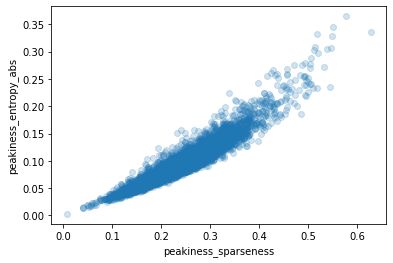

In [658]:
# comparing two measures

pairs = []
for i in range(500):
    # get a fake pmi matrix: 
    # a random square matrix size 5 to 30, populated with values in [-7,7]
    d = np.random.randint(25)+5
    pmis = 14 * np.random.sample((d,d)) - 7
    pmis = pmis + np.transpose(pmis) # symmetrize
    peakiness1 = np.apply_along_axis(peakiness_sparseness, axis=1, arr=pmis)
    peakiness2 = np.apply_along_axis(peakiness_entropy_abs, axis=1, arr=pmis)
    pairs += list(zip(peakiness1,peakiness2))

plt.scatter(*zip(*pairs),alpha = 0.2)
plt.xlabel('peakiness_sparseness')
plt.ylabel('peakiness_entropy_abs')
plt.show()

The for vectors in the middle range, 'entropy_abs' measure is generally a bit lower than 'sparseness', but they're probably going to be similar, pracically.

In [670]:
# some examples
RESULTS_DIR = "results-clean/xlnet-base-cased_pad30_2020-07-04-17-13/" 
matrices_npz = np.load(os.path.join(RESULTS_DIR, 'pmi_matrices.npz'))
logliks_npz = np.load(os.path.join(RESULTS_DIR, 'pseudo_logliks.npz'))

scores_path = glob.glob(RESULTS_DIR+'scores*.csv')[0]
wordpair_path = glob.glob(RESULTS_DIR+'wordpair*.csv')[0]
wordpair = pd.read_csv(wordpair_path)
scores = pd.read_csv(scores_path)

count=0
for sentence, matrix in npz.items():
    sent = sentence.split(' ')
    if 4 < len(sent) < 8:
        print(f'{sent[0]}\tsparseness\tentropy_abs')
        matrix = matrix + np.transpose(matrix) # symmetrize
        for i, row in enumerate(matrix):
            row = row[np.arange(len(row))!=i] # remove diagonal
            print(f'\t{peakiness_sparseness(row):.6f}\t{peakiness_entropy_abs(row):.6f}\t{sent[i]}')
        print()
        count+=1
        if count > 3:
            break

Terms	sparseness	entropy_abs
	0.419852	0.259571	Terms
	0.532268	0.349299	were
	0.618737	0.380415	n't
	0.272665	0.192839	disclosed
	0.371175	0.196616	.

I	sparseness	entropy_abs
	0.486586	0.342948	I
	0.307111	0.196480	love
	0.278812	0.173034	'em
	0.470286	0.303263	both
	0.280670	0.195996	.

``	sparseness	entropy_abs
	0.472149	0.253110	``
	0.370721	0.239387	That
	0.598013	0.365140	's
	0.601621	0.400655	baseball
	0.400749	0.228238	.

``	sparseness	entropy_abs
	0.382789	0.230572	``
	0.215119	0.096626	It
	0.461062	0.245591	's
	0.642375	0.484666	very
	0.421675	0.253724	frustrating
	0.717502	0.503182	.
	0.739722	0.458676	''



# Correlation with dependency accuracy

## Average

First, does average peakiness correlate with sentence-wide accuracy?

In [672]:
# !run cell at bottom to get observations first
av_sparseness = []
av_entropyabs = []
for i, obs in enumerate(tqdm(OBSERVATIONS)):
    sentence = str(' '.join(obs.sentence))
    matrix = matrices_npz[sentence]
    pseudo_loglik = logliks_npz[sentence]
    
    matrix = matrix + np.transpose(matrix) # symmetrize
    row_sparseness = []
    row_entropyabs = []
    peakiness1 = np.apply_along_axis(peakiness_sparseness, axis=1, arr=matrix)
    peakiness2 = np.apply_along_axis(peakiness_entropy_abs, axis=1, arr=matrix)
    av_sparseness.append(np.mean(peakiness1))
    av_entropyabs.append(np.mean(peakiness2))

scores["av_sparseness"] = av_sparseness
scores["av_entropyabs"] = av_entropyabs

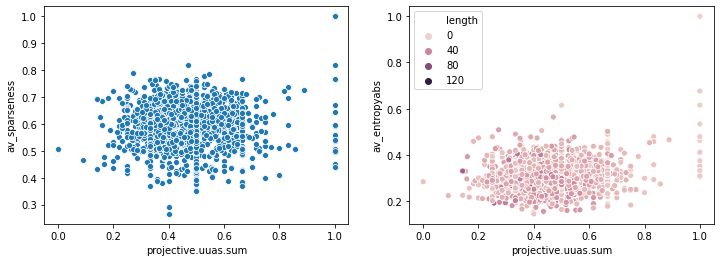

In [784]:
scores['length'] = scores['sentence_length'].astype(float)
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
sns.scatterplot(x='projective.uuas.sum', y='av_sparseness',
                 data=scores, ax=axs[0])
sns.scatterplot(x='projective.uuas.sum', y='av_entropyabs', hue='length',
                 data=scores, ax=axs[1])
# fig.colorbar(fig)
plt.show()

It doesn't look correlated.

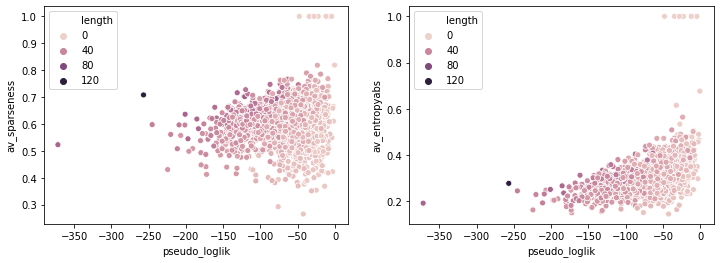

In [783]:
# just out of curiosity, does sparseness correlate with log likelihood?
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
sns.scatterplot(x='pseudo_loglik', y='av_sparseness', hue='length',
                 data=scores, ax=axs[0])
sns.scatterplot(x='pseudo_loglik', y='av_entropyabs', hue='length',
                 data=scores, ax=axs[1])
# fig.colorbar(fig)
plt.show()

## Per word

In [764]:
wordpair_path = glob.glob(RESULTS_DIR+'wordpair*')[0]
wordpair = pd.read_csv(wordpair_path)
wordpair_gold = wordpair[wordpair.gold_edge==True]

In [774]:
# !run cell at bottom to get observations first
av_sparseness = []
av_entropyabs = []
for i, obs in enumerate(tqdm(OBSERVATIONS)):
    sentence = str(' '.join(obs.sentence))
    matrix = matrices_npz[sentence]
    pseudo_loglik = logliks_npz[sentence]
    
    matrix = matrix + np.transpose(matrix) # symmetrize
    row_sparseness = []
    row_entropyabs = []
    peakiness1 = np.apply_along_axis(peakiness_sparseness, axis=1, arr=matrix)
    peakiness2 = np.apply_along_axis(peakiness_entropy_abs, axis=1, arr=matrix)

scores["av_sparseness"] = av_sparseness
scores["av_entropyabs"] = av_entropyabs

,sentence_index,i1,i2,lin_dist,w1,w2,UPOS1,UPOS2,XPOS1,XPOS2,...,pmi_triu,pmi_tril,pmi_edge_sum,pmi_edge_nonproj_sum,pmi_edge_triu,pmi_edge_nonproj_triu,pmi_edge_tril,pmi_edge_nonproj_tril,pmi_edge_none,pmi_edge_nonproj_none
595,1,0,1,1,The,bill,DET,NOUN,DT,NN,...,3.14639,0.710405,True,True,True,True,True,False,True,True


# Extra stuff : reading data

In [ ]:
from collections import namedtuple
class CONLLReader():
    def __init__(self, conll_cols, additional_field_name=None):
        if additional_field_name:
            conll_cols += [additional_field_name]
        self.conll_cols = conll_cols
        self.observation_class = namedtuple("Observation", conll_cols)
        self.additional_field_name = additional_field_name

    # Data input
    @staticmethod
    def generate_lines_for_sent(lines):
        '''Yields batches of lines describing a sentence in conllx.

        Args:
            lines: Each line of a conllx file.
        Yields:
            a list of lines describing a single sentence in conllx.
        '''
        buf = []
        for line in lines:
            if line.startswith('#'):
                continue
            if not line.strip():
                if buf:
                    yield buf
                    buf = []
                else:
                    continue
            else:
                buf.append(line.strip())
        if buf:
            yield buf

    def load_conll_dataset(self, filepath):
        '''Reads in a conllx file; generates Observation objects

        For each sentence in a conllx file, generates a single Observation
        object.

        Args:
            filepath: the filesystem path to the conll dataset
            observation_class: namedtuple for observations

        Returns:
        A list of Observations
        '''
        observations = []
        lines = (x for x in open(filepath))
        for buf in self.generate_lines_for_sent(lines):
            conllx_lines = []
            for line in buf:
                conllx_lines.append(line.strip().split('\t'))
            if self.additional_field_name:
                newfield = [None for x in range(len(conllx_lines))]
                observation = self.observation_class(
                    *zip(*conllx_lines), newfield)
            else:
                observation = self.observation_class(
                    *zip(*conllx_lines))
            observations.append(observation)
        return observations

CONLL_COLS = ['index',
              'sentence',
              'lemma_sentence',
              'upos_sentence',
              'xpos_sentence',
              'morph',
              'head_indices',
              'governance_relations',
              'secondary_relations',
              'extra_info']

OBSERVATIONS = CONLLReader(CONLL_COLS).load_conll_dataset(
    'ptb3-wsj-data/ptb3-wsj-dev.conllx')

Note, there are duplicate sentences.

In [644]:
from collections import defaultdict

def list_duplicates(triple):
    tally = defaultdict(list)
    for i,sent,_ in triple:
        tally[sent].append(i)
    return ((locs,key) for key,locs in tally.items() 
                            if len(locs)>1)

pd.DataFrame(
    list_duplicates(idx_sentence_matrix_triples),
    columns=['indices','sentence']).style.set_properties(
    **{'text-align': 'left', 'display.max_colwidth': -1}).set_table_styles(
    [ dict(selector='th', props=[('text-align', 'left')] ) ])

,indices,sentence
0,"[202, 1546]","Then , nine minutes later , Wall Street suddenly rebounded to a gain on the day ."
1,"[825, 1556]","Among Big Board specialists , the cry was `` Pull your offers '' -- meaning that specialists soon expected to get higher prices for their shares ."
2,"[826, 1557]","`` It was bedlam on the upside , '' said one Big Board specialist ."
3,"[828, 1564]","The carnage on the Chicago Board Options Exchange , the nation 's major options market , was heavy after the trading in S&P 100 stock-index options was halted Friday ."
4,"[829, 1565]","Many market makers in the S&P 100 index options contract had bullish positions Friday , and when the shutdown came they were frozen with huge losses ."
5,"[830, 1566]","Over the weekend , clearing firms told the Chicago market makers to get out of their positions at any cost Monday morning ."
6,"[831, 1567]","`` They were absolutely killed , slaughtered , '' said one Chicago-based options trader ."
7,"[1276, 1278]",Source : Telerate Systems Inc .
